## Systematic Selling

### Summary 

In this note I look at running a simple backtest where I sell a 1m10y straddle each day. I examine premium collected at inception, payout on option expiry and mark-to-market over the life of the trade. 

Look out for future publications where I will build on this strategy with added delta hedging and add analytics for understanding strategy performance!

The content of this notebook is split into:
* [1 - Let's get started with gs quant](#1---Let's-get-started-with-gs-quant)
* [2 - Create portfolio](#2---Create-portfolio)
* [3 - Evaluate portfolio historically](#3---Evaluate-portfolio-historically)
* [4 - Putting it all together](#4---Putting-it-all-together)

### 1 - Let's get started with gs quant
Start every session with authenticating with your unique client id and secret. If you don't have a registered app, create one [here](https://marquee.gs.com/s/developer/myapps/register). `run_analytics` scope is required for the functionality covered in this example. Below produced using gs-quant version 0.8.102.

In [1]:
from gs_quant.session import GsSession
GsSession.use(client_id=None, client_secret=None, scopes=('run_analytics',)) 

### 2 - Create portfolio
Let's create a portfolio with a rolling strip of straddles. For each date in our date range (start of 2019 through today), we will construct a 1m10y straddle and include it in our portfolio.

In [52]:
from gs_quant.markets.portfolio import Portfolio
from gs_quant.common import Currency, PayReceive
from gs_quant.instrument import IRSwaption
from gs_quant.markets import HistoricalPricingContext
from datetime import datetime
from datetime import date

with HistoricalPricingContext(start=date(2019, 1, 1), end=datetime.today().date()): 
    f = IRSwaption(PayReceive.Straddle, '10y', Currency.USD, expiration_date='1m', notional_amount=1e8,
                   buy_sell='Sell').resolve(in_place=False)

portfolio = Portfolio([v[1] for v in sorted(f.result().items())])

We can use `to_frame` to take a look at our portfolio and resolved instrument details as a dataframe. Let's also convert date representations to date types and remove any instruments iwth premium_payment_date larger than today.

In [88]:
frame = portfolio.to_frame()
frame.premium_payment_date = frame.premium_payment_date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())
frame.expiration_date = frame.expiration_date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())
frame = frame[frame.premium_payment_date < datetime.today().date()]
frame.head()

,asset_class,buy_sell,effective_date,expiration_date,fee,fee_currency,fee_payment_date,fixed_rate_business_day_convention,fixed_rate_day_count_fraction,fixed_rate_frequency,...,floating_rate_spread,notional_amount,notional_currency,pay_or_receive,premium,premium_payment_date,settlement,strike,termination_date,type
instrument,,,,,,,,,,,,,,,,,,,,,
<gs_quant.target.instrument.IRSwaption object at 0x0000000010E43EF0>,AssetClass.Rates,BuySell.Sell,2019-02-05,2019-02-01,0.0,Currency.USD,2019-01-03,BusinessDayConvention.Modified_Following,DayCountFraction._30_OVER_360,6m,...,0.0,100000000.0,Currency.USD,Straddle,0.0,2019-01-03,SwapSettlement.Phys_CLEARED,0.027521,2029-02-05,AssetType.Swaption
<gs_quant.target.instrument.IRSwaption object at 0x0000000010A39128>,AssetClass.Rates,BuySell.Sell,2019-02-06,2019-02-04,0.0,Currency.USD,2019-01-04,BusinessDayConvention.Modified_Following,DayCountFraction._30_OVER_360,6m,...,0.0,100000000.0,Currency.USD,Straddle,0.0,2019-01-04,SwapSettlement.Phys_CLEARED,0.027023,2029-02-06,AssetType.Swaption
<gs_quant.target.instrument.IRSwaption object at 0x000000001229C080>,AssetClass.Rates,BuySell.Sell,2019-02-06,2019-02-04,0.0,Currency.USD,2019-01-07,BusinessDayConvention.Modified_Following,DayCountFraction._30_OVER_360,6m,...,0.0,100000000.0,Currency.USD,Straddle,0.0,2019-01-07,SwapSettlement.Phys_CLEARED,0.026022,2029-02-06,AssetType.Swaption
<gs_quant.target.instrument.IRSwaption object at 0x0000000010657E10>,AssetClass.Rates,BuySell.Sell,2019-02-06,2019-02-04,0.0,Currency.USD,2019-01-08,BusinessDayConvention.Modified_Following,DayCountFraction._30_OVER_360,6m,...,0.0,100000000.0,Currency.USD,Straddle,0.0,2019-01-08,SwapSettlement.Phys_CLEARED,0.026939,2029-02-06,AssetType.Swaption
<gs_quant.target.instrument.IRSwaption object at 0x000000000FB24A58>,AssetClass.Rates,BuySell.Sell,2019-02-11,2019-02-07,0.0,Currency.USD,2019-01-09,BusinessDayConvention.Modified_Following,DayCountFraction._30_OVER_360,6m,...,0.0,100000000.0,Currency.USD,Straddle,0.0,2019-01-09,SwapSettlement.Phys_CLEARED,0.026930,2029-02-11,AssetType.Swaption


### 3 - Evaluate portfolio historically
Let's now evaluate each instrument for the relevant date range (inception to option expiry).

Note that I use the async flag in pricing context - this is what makes computing 9000 points so fast (~300 instruments * ~30 days)! It sends off a request for 1 month of data for each instrument to be computed in parallel. I keep track of each future in our portfolio frame.

To learn more about async and other compute controls and how to use them, please see our [pricing context guide](https://developer.gs.com/docs/gsquant/guides/Pricing-and-Risk/pricing-context/). 

In [89]:
frame['future'] = len(frame) * [None]

for inst, row in frame.iterrows():
    with HistoricalPricingContext(start=row.premium_payment_date, end=row.expiration_date, is_async=True):
        pv = inst.price()
    frame.at[inst, 'future'] = pv

We can now grab all the results and organize them into a dataframe. This call will wait for all the results to come back from the pool so it's as fast as the slowest single request out of the ~300 we sent in the previous step.

In [92]:
import pandas as pd

timeseries = pd.concat([pd.Series(row.future.result(), name=row.name) for _, row in frame.iterrows()], axis=1, sort=True)

### 4 - Putting it all together
With the portfolio and historical PV's in hand, let's comb through the data to tease out components we want to track: premium collected, payout on expiry and mark-to-mark of the swaption.

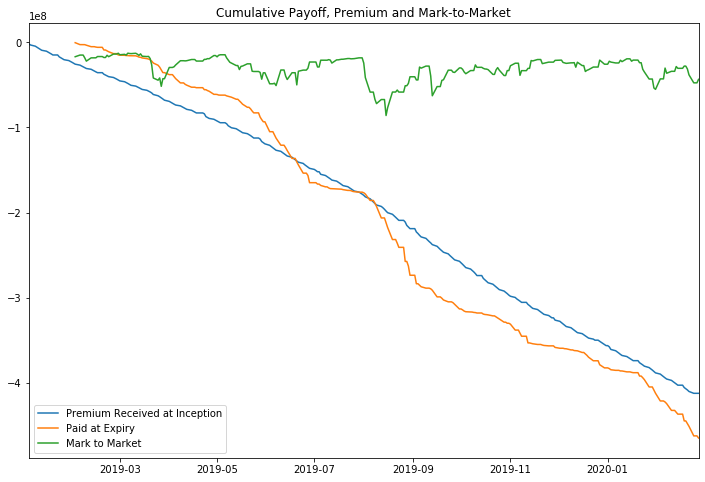

In [97]:
import matplotlib.pyplot as plt
from collections import defaultdict

def get_p(df, first=True):
    p_p = df.apply(lambda series: series.first_valid_index() if first else series.last_valid_index())
    g = defaultdict(float)
    for i, r in p_p.items():
        g[r]+=df[i][r]
    return pd.Series(g)

premia = get_p(timeseries)
payoffs = get_p(timeseries, first=False)
mtm = timeseries.fillna(0).sum(axis=1)-payoffs

overview = pd.concat([premia.cumsum(), payoffs.cumsum(), mtm], axis=1, sort=False)
overview.columns = ['Premium Received at Inception', 'Paid at Expiry', 'Mark to Market']
overview = overview.sort_index()
overview = overview.fillna(method='ffill')[:datetime.today().date()]
overview.plot(figsize=(12, 8), title='Cumulative Payoff, Premium and Mark-to-Market')

From the above, we can see that premium received at inception varies relative to payout at expiry. We can see when this is the case more clearly by looking at the difference between the two.

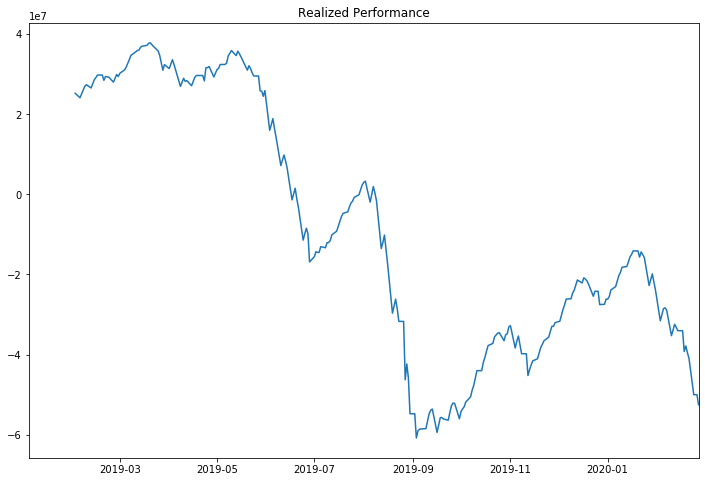

In [98]:
(overview['Paid at Expiry'] - overview['Premium Received at Inception']).plot(figsize=(12, 8), title='Realized Performance')

But looking at only premium collected and amount paid out doesn't speak to the volatility of this strategy - let's add mark-to-market in to see that. 

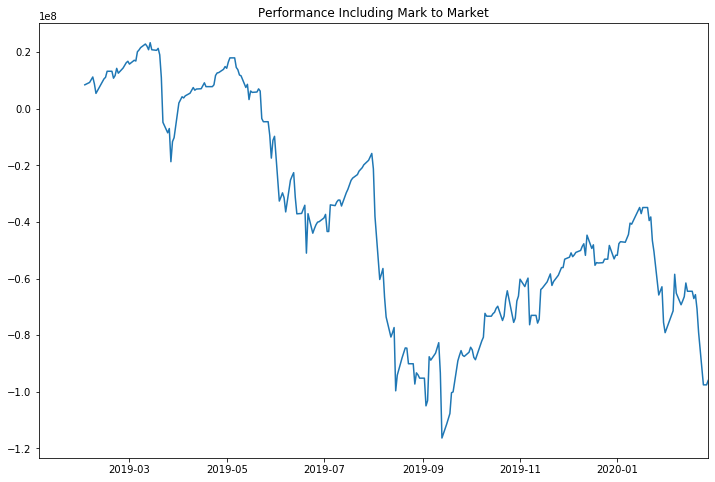

In [99]:
(overview['Paid at Expiry'] - overview['Premium Received at Inception'] + 
 overview['Mark to Market']).plot(figsize=(12, 8), title='Performance Including Mark to Market')

As we can see above, since beginning of 2019 this has mostly been a losing strategy although it has worked well 4Q19.

Stay tuned to futher editions of gs quant for ways to modify this strategy (delta hedging, for example) and to analyze performance of strategies like this one.

### Disclaimer
This website may contain links to websites and the content of third parties ("Third Party Content"). We do not monitor, review or update, and do not have any control over, any Third Party Content or third party websites. We make no representation, warranty or guarantee as to the accuracy, completeness, timeliness or reliability of any Third Party Content and are not responsible for any loss or damage of any sort resulting from the use of, or for any failure of, products or services provided at or from a third party resource. If you use these links and the Third Party Content, you acknowledge that you are doing so entirely at your own risk.